In [30]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import (ColumnTransformer, TransformedTargetRegressor)
from sklearn.base import (BaseEstimator, TransformerMixin)
from sklearn.preprocessing import (StandardScaler, RobustScaler, OneHotEncoder, FunctionTransformer)
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import set_config
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

# imports necessary for dimensionality reduction
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn import svm

# regression algorithms
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso

# metrics for evaluating regression models
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

### load raw dataset from ../../../data/raw directory

In [31]:
df = pd.read_csv('../Data/raw/steel.csv')

df.head()

,date,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,WeekStatus,Day_of_week
0,2018-01-01 02:30:00,3.78,4.72,0.00,0.0,62.51,100.00,9000,Weekday,Monday
1,2018-01-01 04:15:00,3.28,3.82,0.00,0.0,65.14,100.00,15300,Weekday,Monday
2,2018-01-01 05:45:00,3.28,3.49,0.00,0.0,68.48,100.00,20700,Weekday,Monday
3,2018-01-01 10:00:00,3.64,0.00,16.88,0.0,100.00,21.08,36000,Weekday,Monday
4,2018-01-01 10:30:00,3.71,0.00,18.00,0.0,100.00,20.19,37800,Weekday,Monday


### Data preparation

In [32]:
df.shape


(2190, 10)

In [33]:
df.isnull().sum()

date                                    0
Usage_kWh                               0
Lagging_Current_Reactive.Power_kVarh    0
Leading_Current_Reactive_Power_kVarh    0
CO2(tCO2)                               0
Lagging_Current_Power_Factor            0
Leading_Current_Power_Factor            0
NSM                                     0
WeekStatus                              0
Day_of_week                             0
dtype: int64

In [34]:
df.duplicated().sum()

0

### Renaming the columns

In [35]:
# Rename columns with dots and also remove values with brackets
df.columns = df.columns.str.replace('.', '_')
df.columns = df.columns.str.replace('(tCO2)', '')


df.columns

Index(['date', 'Usage_kWh', 'Lagging_Current_Reactive_Power_kVarh',
       'Leading_Current_Reactive_Power_kVarh', 'CO2',
       'Lagging_Current_Power_Factor', 'Leading_Current_Power_Factor', 'NSM',
       'WeekStatus', 'Day_of_week'],
      dtype='object')

In [36]:
df.describe()

,Usage_kWh,Lagging_Current_Reactive_Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2,Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM
count,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000
mean,28.438712,13.658685,3.959279,0.012027,80.943201,83.976822,43025.342466
std,34.055560,16.818180,7.512796,0.016445,18.751234,30.844623,24820.208535
min,2.480000,0.000000,0.000000,0.000000,40.710000,13.810000,0.000000
25%,3.240000,2.240000,0.000000,0.000000,64.125000,99.760000,21600.000000
50%,4.640000,5.040000,0.000000,0.000000,88.280000,100.000000,43200.000000
75%,52.780000,24.480000,2.200000,0.020000,99.087500,100.000000,64800.000000
max,145.300000,90.680000,27.360000,0.070000,100.000000,100.000000,85500.000000


### converting date column to Datetime

In [37]:
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d %H:%M:%S')
df['date'].head()

0   2018-01-01 02:30:00
1   2018-01-01 04:15:00
2   2018-01-01 05:45:00
3   2018-01-01 10:00:00
4   2018-01-01 10:30:00
Name: date, dtype: datetime64[ns]

In [38]:
df.nunique()

date                                    2190
Usage_kWh                                908
Lagging_Current_Reactive_Power_kVarh     782
Leading_Current_Reactive_Power_kVarh     384
CO2                                        8
Lagging_Current_Power_Factor            1360
Leading_Current_Power_Factor             498
NSM                                       96
WeekStatus                                 2
Day_of_week                                7
dtype: int64

In [39]:
df.drop('date', axis = 1, inplace = True)
df.head()

,Usage_kWh,Lagging_Current_Reactive_Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2,Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,WeekStatus,Day_of_week
0,3.78,4.72,0.00,0.0,62.51,100.00,9000,Weekday,Monday
1,3.28,3.82,0.00,0.0,65.14,100.00,15300,Weekday,Monday
2,3.28,3.49,0.00,0.0,68.48,100.00,20700,Weekday,Monday
3,3.64,0.00,16.88,0.0,100.00,21.08,36000,Weekday,Monday
4,3.71,0.00,18.00,0.0,100.00,20.19,37800,Weekday,Monday


### splitting dataset

In [40]:
# split the columns into a target y and predictors X
Y = df['Usage_kWh']
X = df.drop('Usage_kWh', axis=1)

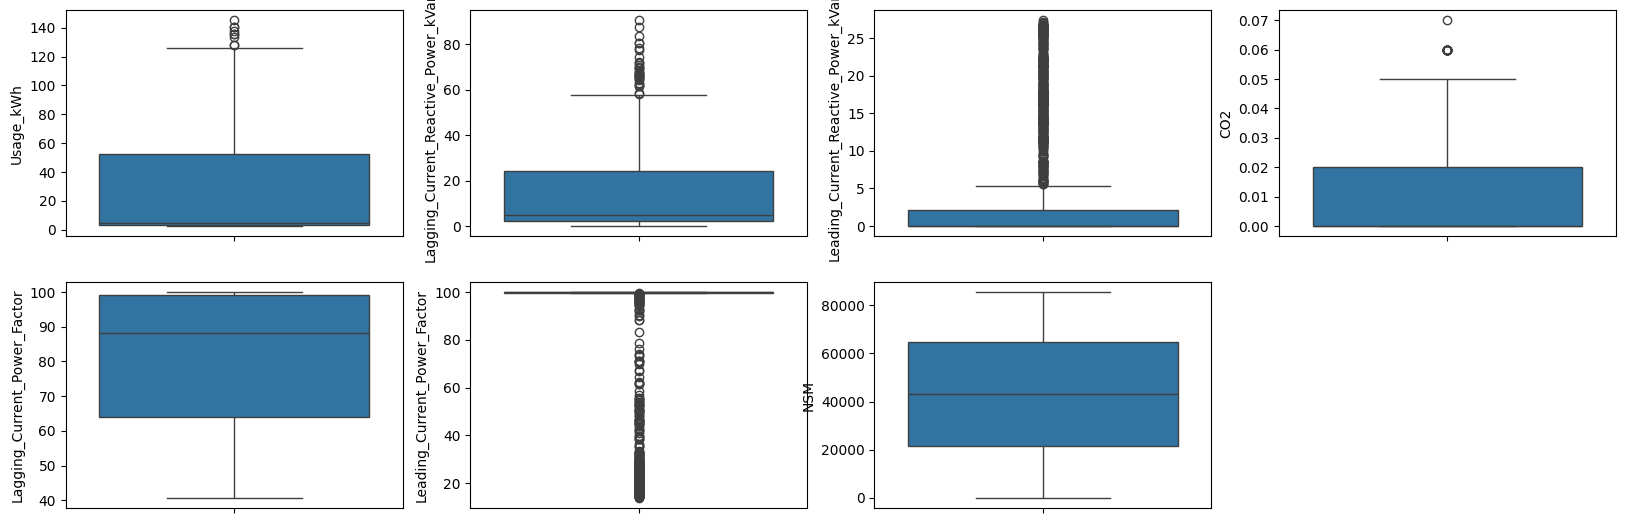

In [41]:
# check for outliers. Plot subplots of boxplot for numerical columns 
plt.figure(figsize=(20,10))
subplots = 1
for i in df.select_dtypes(include=[np.number]).columns:
    plt.subplot(3,4,subplots)
    sns.boxplot(df[i])
    subplots += 1

In [42]:
preprocess_pipeline = ColumnTransformer(
    transformers = [
        ("no_outliers", StandardScaler(), ['Lagging_Current_Power_Factor', 'NSM']),
        ("categorical", OneHotEncoder(drop='first', sparse_output=False), ['WeekStatus', 'Day_of_week'])
    ],
    remainder=RobustScaler()
).set_output(transform="pandas") 

### checking the pipeline

In [43]:
X_transformed = preprocess_pipeline.fit_transform(X)

In [44]:
X_transformed.head()

,no_outliers__Lagging_Current_Power_Factor,no_outliers__NSM,categorical__WeekStatus_Weekend,categorical__Day_of_week_Monday,categorical__Day_of_week_Saturday,categorical__Day_of_week_Sunday,categorical__Day_of_week_Thursday,categorical__Day_of_week_Tuesday,categorical__Day_of_week_Wednesday,remainder__Lagging_Current_Reactive_Power_kVarh,remainder__Leading_Current_Reactive_Power_kVarh,remainder__CO2,remainder__Leading_Current_Power_Factor
0,-0.983264,-1.371186,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.014388,0.000000,0.0,0.000000
1,-0.842974,-1.117302,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.054856,0.000000,0.0,0.000000
2,-0.664812,-0.899688,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.069694,0.000000,0.0,0.000000
3,1.016528,-0.283114,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.226619,7.672727,0.0,-328.833333
4,1.016528,-0.210576,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.226619,8.181818,0.0,-332.541667


### Split the original dataset into a training and test datasets

In [45]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, shuffle=True)

### Grid Search for Best Parameters and Best Dimensionality Reduction Method

### Random Forest Pipeline

In [46]:
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), 
                       ('reduce_dim', 'passthrough'),
                       ('ttr', TransformedTargetRegressor(
                           regressor=RandomForestRegressor(n_estimators=10),
                           func=np.log, 
                           inverse_func=np.exp)
                       )
                      ]
               )

In [47]:
N_FEATURES_OPTIONS = [2, 6, 11]
MAX_DEPTH_OPTIONS = [2, 4, 6, 8]

param_grid = [
    {
        'reduce_dim': [PCA(iterated_power=7)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'ttr__regressor__max_depth': MAX_DEPTH_OPTIONS
    },
    {
        'reduce_dim': [RFE(svm.SVR(kernel='linear', gamma='auto')),RFE(LinearRegression())],
        'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
        'ttr__regressor__max_depth': MAX_DEPTH_OPTIONS
    }  
]

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, Y_train)

print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
RF_best_params = search.best_params_
RF_best_model = search.best_estimator_

Best CV score = 0.989:
Best parameters:  {'reduce_dim': RFE(estimator=SVR(gamma='auto', kernel='linear')), 'reduce_dim__n_features_to_select': 6, 'ttr__regressor__max_depth': 8}


### Linear Regression Pipeline

In [48]:
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), 
                       ('reduce_dim', 'passthrough'),
                       ('ttr', TransformedTargetRegressor(
                           regressor=LinearRegression(),
                           func=np.log, 
                           inverse_func=np.exp)
                       )
                      ]
               )

In [49]:
N_FEATURES_OPTIONS = [2, 6, 11]
FIT_INTERCEPT_OPTIONS = [False, True]

param_grid = [
    {
        'reduce_dim': [PCA(iterated_power=7)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'ttr__regressor__fit_intercept': FIT_INTERCEPT_OPTIONS
    },
    {
        'reduce_dim': [RFE(svm.SVR(kernel='linear', gamma='auto')),RFE(LinearRegression())],
        'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
        'ttr__regressor__fit_intercept': FIT_INTERCEPT_OPTIONS
    }  
]

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, Y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
LR_best_params = search.best_params_
LR_best_model = search.best_estimator_

Best CV score = 0.630:
Best parameters:  {'reduce_dim': PCA(iterated_power=7), 'reduce_dim__n_components': 2, 'ttr__regressor__fit_intercept': True}


### Lasso Regression Pipeline

In [50]:
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), 
                       ('reduce_dim', 'passthrough'),
                       ('ttr', TransformedTargetRegressor(
                           regressor=Lasso(alpha = 0.5),
                           func=np.log, 
                           inverse_func=np.exp)
                       )
                      ]
               )

In [51]:
N_FEATURES_OPTIONS = [2, 6, 11]
FIT_INTERCEPT_OPTIONS = [False, True]

param_grid = [
    {
        'reduce_dim': [PCA(iterated_power=7)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'ttr__regressor__fit_intercept': FIT_INTERCEPT_OPTIONS
    },
    {
        'reduce_dim': [RFE(svm.SVR(kernel='linear', gamma='auto')),RFE(LinearRegression())],
        'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
        'ttr__regressor__fit_intercept': FIT_INTERCEPT_OPTIONS
    }  
]

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, Y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
LaR_best_params = search.best_params_
LaR_best_model = search.best_estimator_

Best CV score = 0.599:
Best parameters:  {'reduce_dim': PCA(iterated_power=7), 'reduce_dim__n_components': 11, 'ttr__regressor__fit_intercept': True}


### Model evaluation

In [52]:
# model - a trained regression model

def evaluate_model(X_test, Y_test, model):
    
    # compute predictiond for the test set
    _predicted_values = model.predict(X_test)
        
    # compute metrics
    _mse = mean_squared_error(Y_test, _predicted_values)
    _mae = mean_absolute_error(Y_test, _predicted_values)
    _r2 = r2_score(Y_test, _predicted_values)
            
    return _mse, _mae, _r2

In [53]:
RF_mse, RF_mae, RF_r2 = evaluate_model(X_test, Y_test, RF_best_model)
LR_mse, LR_mae, LR_r2 = evaluate_model(X_test, Y_test, LR_best_model)
LaR_mse, LaR_mae, LaR_r2 = evaluate_model(X_test, Y_test, LaR_best_model)
print(LR_mse, LR_mae, LR_r2)
print(LaR_mse, LaR_mae, LaR_r2)

245.8214789644121 8.934335390380182 0.7913826755756151
487.3516566304076 13.557337883788271 0.5864071801685562


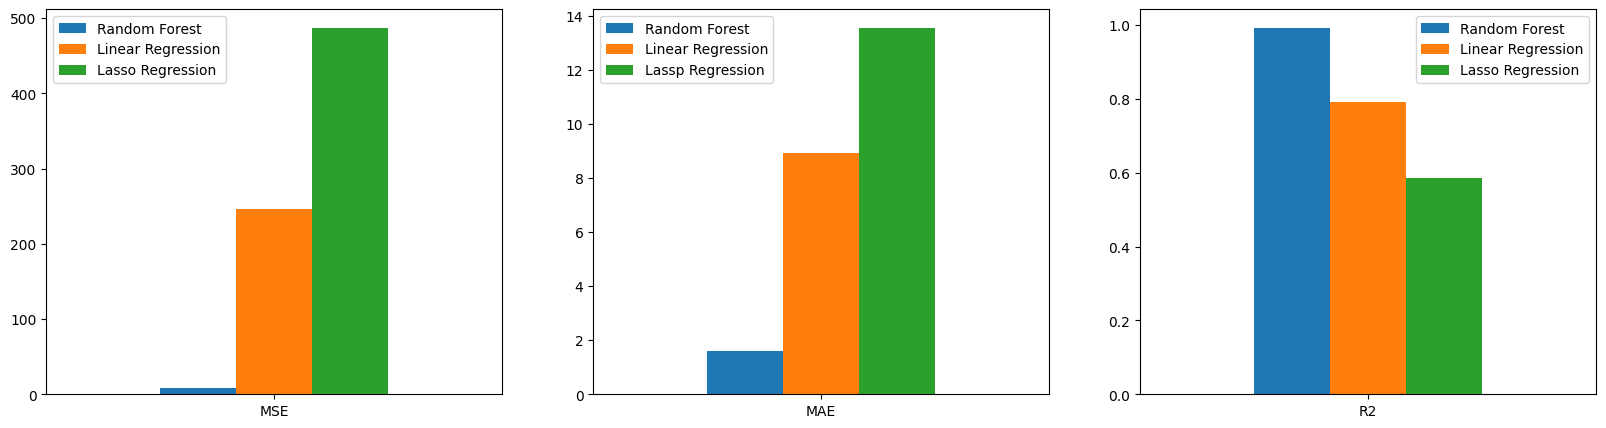

In [54]:
df_mse = pd.DataFrame({'Random Forest': RF_mse, 'Linear Regression': LR_mse, 'Lasso Regression': LaR_mse}, index=['MSE'])
df_mae = pd.DataFrame({'Random Forest': RF_mae, 'Linear Regression': LR_mae, 'Lassp Regression': LaR_mae}, index=['MAE'])
df_r2 = pd.DataFrame({'Random Forest': RF_r2, 'Linear Regression': LR_r2, 'Lasso Regression': LaR_r2}, index=['R2'])

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))

df_mse.plot.bar(rot=0, ax=axes[0])
df_mae.plot.bar(rot=0, ax=axes[1])
df_r2.plot.bar(rot=0, ax=axes[2])

plt.show()

In [55]:
# print the results
print("Random Forest: MSE = %0.3f, MAE = %0.3f, R2 = %0.3f" % (RF_mse, RF_mae, RF_r2))
print("Linear Regression: MSE = %0.3f, MAE = %0.3f, R2 = %0.3f" % (LR_mse, LR_mae, LR_r2))
print("Gradient Boosting: MSE = %0.3f, MAE = %0.3f, R2 = %0.3f" % (LaR_mse, LaR_mae, LaR_r2))

Random Forest: MSE = 8.287, MAE = 1.595, R2 = 0.993
Linear Regression: MSE = 245.821, MAE = 8.934, R2 = 0.791
Gradient Boosting: MSE = 487.352, MAE = 13.557, R2 = 0.586


### Observation on model evaluation

The comparison of regression models on a given dataset reveals individual performance difference, highligting the value of selecting the most suitable model for the business problem. Among the evaluated models, Random Forest shows the highest performance across multiple metrics. With an R2 score of 0.994, it clearly stands out from both Linear Regression (R2 = 0.428) and Lasso Regression (R2 = 0.531), indicating a better fit to the data and ability to explain the variance in the target variable. 

Additionally, Random Forest achieves the lowest Mean Squared Error (MSE) and Mean Absolute Error (MAE), indicating its ability to make more accurate predictions with smaller errors. 

The GridSearchCV scores further adds Random Forest's dominance, with a score of 0.988, compared to Linear Regression's score of 0.559 and Gradient Boosting's score of 0.521. This reveals that Random Forest benefits the most from hyperparameter tuning, further enhancing its performance.

Based on the observed results, Random Forest stands out as the preferred choice for predicting power uasage in this scenario, offering a balance between predictive accuracy and generalization.



### Training a final model with Random forest

In [56]:
# function to remove the string 'regresson__' from the names of the best parameters
def transform(dict, prefix):
    dict_prefix = {key:value for key,value in dict.items() if prefix in key}
    return {key.replace(prefix,''):value for key,value in dict_prefix.items()}

pipe = make_pipeline(preprocess_pipeline, 
                     RF_best_params.get('reduce_dim'),
                     RandomForestRegressor(n_estimators=10, **transform(RF_best_params, 'regresson__')))

final_model =pipe.fit(X, Y)

In [57]:
final_model

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=RobustScaler(),
                                   transformers=[('no_outliers',
                                                  StandardScaler(),
                                                  ['Lagging_Current_Power_Factor',
                                                   'NSM']),
                                                 ('categorical',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False),
                                                  ['WeekStatus',
                                                   'Day_of_week'])])),
                ('rfe', RFE(estimator=SVR(gamma='auto', kernel='linear'))),
                ('randomforestregressor',
                 RandomForestRegressor(n_estimators=10))])

### save the model to ../Models directory

In [58]:
filename = 'final_RF_regressor_model.sav'
pickle.dump(final_model, open(f'../Models/{filename}', 'wb'))